<a href="https://colab.research.google.com/github/anandhulk/MainProject/blob/main/Tranformer_model_fine-tuning_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.2 MB/s eta 0:00:00


In [2]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.0 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Tue Apr 25 03:25:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from tqdm import tqdm
import torch
import nltk
from nltk.corpus import stopwords

# Download the list of stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [ ]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [5]:
dataset_sci = load_dataset("tomasg25/scientific_lay_summarisation","plos")

split_lengths = [len(dataset_sci[split])for split in dataset_sci]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_sci['train'].column_names}")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/24773 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1376 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1376 [00:00<?, ? examples/s]

Dataset scientific_lay_summarisation downloaded and prepared to /root/.cache/huggingface/datasets/tomasg25___scientific_lay_summarisation/plos/1.0.0/bf538a761aabe5d3389d3e4aa028b094528c5d7a6225147b843a63a3803e79f4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [24773, 1376, 1376]
Features: ['article', 'summary', 'section_headings', 'keywords', 'year', 'title']


In [ ]:
article=dataset_sci["test"][2]["article"]
print(article)
print(" ")
print("SUMMARY:")
print(dataset_sci["test"][2]["summary"])

Leishmaniasis , resulting from infection with the protozoan parasite Leishmania , consists of a wide spectrum of clinical manifestations , from healing cutaneous lesions to fatal visceral infections . A particularly severe form of cutaneous leishmaniasis , termed mucosal leishmaniasis , exhibits decreased IL-10 levels and an exaggerated inflammatory response that perpetuates the disease . Using a mouse model of leishmaniasis , we investigated what cytokines contribute to increased pathology when IL-10-mediated regulation is absent . Leishmania major infected C57BL/6 mice lacking IL-10 regulation developed larger lesions than controls , but fewer parasites . Both IFN-γ and IL-17 levels were substantially elevated in mice lacking the capacity to respond to IL-10 . IFN-γ promoted an increased infiltration of monocytes , while IL-17 contributed to an increase in neutrophils . Surprisingly , however , we found that IFN-γ did not contribute to increased pathology , but instead regulated the 

In [ ]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):
    cleaned=[]
    for row in column['article']:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        cleaned.append(row)
    return{
        "cleaned":cleaned
    }

In [ ]:
dataset=dataset_sci.map(text_strip,batched=True)

Map:   0%|          | 0/24773 [00:00<?, ? examples/s]

Map:   0%|          | 0/1376 [00:00<?, ? examples/s]

Map:   0%|          | 0/1376 [00:00<?, ? examples/s]

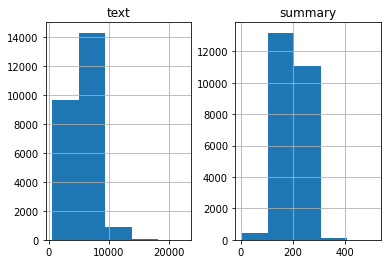

In [ ]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in dataset['train']['cleaned']:
    text_count.append(len(sent.split()))
    
for sent in dataset['train']['summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [ ]:
from datasets import DatasetDict
num_rows=len(dataset['train']['cleaned'])
new_dataset = dataset['train'].select(range(num_rows // 2))
new_dataset_dict = DatasetDict({'train': new_dataset, 'test': dataset['test'],'validation':dataset['validation']})
dataset=new_dataset_dict

In [6]:
train_data=dataset_sci['validation']
train_data.save_to_disk("test_data")

Saving the dataset (0/1 shards):   0%|          | 0/1376 [00:00<?, ? examples/s]

In [ ]:
dataset=dataset.remove_columns(['article', 'section_headings', 'keywords', 'year', 'title'])
dataset

DatasetDict({
    train: Dataset({
        features: ['summary', 'cleaned'],
        num_rows: 12386
    })
    test: Dataset({
        features: ['summary', 'cleaned'],
        num_rows: 1376
    })
    validation: Dataset({
        features: ['summary', 'cleaned'],
        num_rows: 1376
    })
})

In [ ]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(data):
    removed=[]
    for row in data['cleaned']:
        words = row.split()

        # Remove the stopwords
        filtered_words = [word for word in words if word.casefold() not in stop_words]

        # Join the remaining words into a new sentence
        new_sentence = ' '.join(filtered_words)
        removed.append(new_sentence)

    return{
        "stopwords":removed
    }

In [ ]:
dataset=dataset.map(remove_stopwords,batched=True)

Map:   0%|          | 0/12386 [00:00<?, ? examples/s]

Map:   0%|          | 0/1376 [00:00<?, ? examples/s]

Map:   0%|          | 0/1376 [00:00<?, ? examples/s]

In [ ]:
dataset=dataset.remove_columns(['cleaned'])

In [ ]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_sci['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'article', column_summary='summary', batch_size=8)

100%|██████████| 172/172 [34:39<00:00, 12.09s/it]


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.017955,0.000227,0.017682,0.017677


In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['stopwords'] , max_length = 1024, truncation = True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True)
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
dataset_tokenized = dataset.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/12386 [00:00<?, ? examples/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1376 [00:00<?, ? examples/s]

Map:   0%|          | 0/1376 [00:00<?, ? examples/s]

In [ ]:
dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['summary', 'stopwords', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 12386
    })
    test: Dataset({
        features: ['summary', 'stopwords', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1376
    })
    validation: Dataset({
        features: ['summary', 'stopwords', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1376
    })
})

In [ ]:
dataset_tokenized.save_to_disk("/content/drive/MyDrive/Datasets/summary")

Saving the dataset (0/1 shards):   0%|          | 0/12386 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1376 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1376 [00:00<?, ? examples/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "Anandhulk/pegasus-scientific_lay_v2.0"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [ ]:
from datasets import load_from_disk

dataset_tokenized = load_from_disk("/content/drive/MyDrive/Datasets/summary")

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-scientific_lay', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='epoch',
    gradient_accumulation_steps=16,
    push_to_hub=True,
    push_to_hub_model_id='pegasus-scientific_lay_v2.0',
    save_steps=1e6,
) 

/usr/local/lib/python3.8/dist-packages/transformers/training_args.py:1334: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case Anandhulk/pegasus-scientific_lay_v2.0).
  warnings.warn(


In [ ]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_tokenized["train"], 
                  eval_dataset=dataset_tokenized["validation"])

Cloning https://huggingface.co/Anandhulk/pegasus-scientific_lay_v2.0 into local empty directory.


Download file pytorch_model.bin:   0%|          | 15.4k/2.13G [00:00<?, ?B/s]

Download file spiece.model:   0%|          | 7.40k/1.82M [00:00<?, ?B/s]

Clean file spiece.model:   0%|          | 1.00k/1.82M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/2.13G [00:00<?, ?B/s]

# **Version 1.0**

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: stopwords, summary. If stopwords, summary are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12386
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 774
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` 

Step,Training Loss,Validation Loss
500,2.823400,2.595457


The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: stopwords, summary. If stopwords, summary are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1376
  Batch size = 1
Saving model checkpoint to pegasus-scientific_lay/checkpoint-774
Configuration saved in pegasus-scientific_lay/checkpoint-774/config.json
Configuration saved in pegasus-scientific_lay/checkpoint-774/generation_config.json
Model weights saved in pegasus-scientific_lay/checkpoint-774/pytorch_model.bin
tokenizer config file saved in pegasus-scientific_lay/checkpoint-774/tokenizer_config.json
Special tokens file saved in pegasus-scientific_lay/checkpoint-774/special_tokens_map.json
tokenizer config file saved in pegasus-scientific_lay/tokenizer_config.json
Special tokens file saved in pegasus-scientific_lay/special_tokens_map.json


Tra

TrainOutput(global_step=774, training_loss=3.120366418084433, metrics={'train_runtime': 9279.9694, 'train_samples_per_second': 1.335, 'train_steps_per_second': 0.083, 'total_flos': 3.578312730555187e+16, 'train_loss': 3.120366418084433, 'epoch': 1.0})

# **Version 2.0**

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, stopwords. If summary, stopwords are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12386
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 1548
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__`

Epoch,Training Loss,Validation Loss
0,2.658400,2.449100


The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, stopwords. If summary, stopwords are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1376
  Batch size = 1
Saving model checkpoint to /content/drive/MyDrive/pegasus-scientific_lay/checkpoint-774
Configuration saved in /content/drive/MyDrive/pegasus-scientific_lay/checkpoint-774/config.json
Configuration saved in /content/drive/MyDrive/pegasus-scientific_lay/checkpoint-774/generation_config.json
Model weights saved in /content/drive/MyDrive/pegasus-scientific_lay/checkpoint-774/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/pegasus-scientific_lay/checkpoint-774/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/pegasus-scientific_lay/checkpoint-774/special_tokens_map.json
tokenizer config fi

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: stopwords, summary. If stopwords, summary are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12386
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 774
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` 

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
0,2.525000,2.370819


The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: stopwords, summary. If stopwords, summary are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1376
  Batch size = 1
Saving model checkpoint to pegasus-scientific_lay/checkpoint-774
Configuration saved in pegasus-scientific_lay/checkpoint-774/config.json
Configuration saved in pegasus-scientific_lay/checkpoint-774/generation_config.json
Model weights saved in pegasus-scientific_lay/checkpoint-774/pytorch_model.bin
tokenizer config file saved in pegasus-scientific_lay/checkpoint-774/tokenizer_config.json
Special tokens file saved in pegasus-scientific_lay/checkpoint-774/special_tokens_map.json
tokenizer config file saved in pegasus-scientific_lay/tokenizer_config.json
Special tokens file saved in pegasus-scientific_lay/special_tokens_map.json


Tra

TrainOutput(global_step=774, training_loss=2.532312417831224, metrics={'train_runtime': 9605.3115, 'train_samples_per_second': 1.289, 'train_steps_per_second': 0.081, 'total_flos': 3.577633537113293e+16, 'train_loss': 2.532312417831224, 'epoch': 1.0})

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, stopwords. If summary, stopwords are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12386
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 774
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` 

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
0,2.500400,2.348238


The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, stopwords. If summary, stopwords are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1376
  Batch size = 1
Saving model checkpoint to pegasus-scientific_lay/checkpoint-774
Configuration saved in pegasus-scientific_lay/checkpoint-774/config.json
Configuration saved in pegasus-scientific_lay/checkpoint-774/generation_config.json
Model weights saved in pegasus-scientific_lay/checkpoint-774/pytorch_model.bin
tokenizer config file saved in pegasus-scientific_lay/checkpoint-774/tokenizer_config.json
Special tokens file saved in pegasus-scientific_lay/checkpoint-774/special_tokens_map.json
tokenizer config file saved in pegasus-scientific_lay/tokenizer_config.json
Special tokens file saved in pegasus-scientific_lay/special_tokens_map.json


Tra

TrainOutput(global_step=774, training_loss=2.408847556249732, metrics={'train_runtime': 8763.9041, 'train_samples_per_second': 1.413, 'train_steps_per_second': 0.088, 'total_flos': 3.577633537113293e+16, 'train_loss': 2.408847556249732, 'epoch': 1.0})

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, stopwords. If summary, stopwords are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12386
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 774
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` 

Epoch,Training Loss,Validation Loss
0,2.489100,2.336693


The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, stopwords. If summary, stopwords are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1376
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=774, training_loss=2.3096247618820622, metrics={'train_runtime': 9351.3854, 'train_samples_per_second': 1.325, 'train_steps_per_second': 0.083, 'total_flos': 3.577633537113293e+16, 'train_loss': 2.3096247618820622, 'epoch': 1.0})

In [ ]:
model_pegasus.save_pretrained("/content/drive/MyDrive/pegasus-scientific_lay")

Configuration saved in /content/drive/MyDrive/pegasus-scientific_lay/config.json
Configuration saved in /content/drive/MyDrive/pegasus-scientific_lay/generation_config.json
Model weights saved in /content/drive/MyDrive/pegasus-scientific_lay/pytorch_model.bin


In [ ]:
tokenizer.save_pretrained("/content/drive/MyDrive/tokenizer")

tokenizer config file saved in /content/drive/MyDrive/tokenizer/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/tokenizer/special_tokens_map.json


('/content/drive/MyDrive/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/tokenizer/spiece.model',
 '/content/drive/MyDrive/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/tokenizer/tokenizer.json')

In [ ]:
trainer.push_to_hub("pegasus-scientific_lay_v2.0")

Saving model checkpoint to pegasus-scientific_lay
Configuration saved in pegasus-scientific_lay/config.json
Configuration saved in pegasus-scientific_lay/generation_config.json
Model weights saved in pegasus-scientific_lay/pytorch_model.bin
tokenizer config file saved in pegasus-scientific_lay/tokenizer_config.json
Special tokens file saved in pegasus-scientific_lay/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 32.0k/2.13G [00:00<?, ?B/s]

Upload file runs/Mar01_06-42-29_59a6e9752b23/events.out.tfevents.1677653434.59a6e9752b23.136.0: 100%|#########…

Upload file training_args.bin: 100%|##########| 3.50k/3.50k [00:00<?, ?B/s]

Upload file runs/Mar01_06-42-29_59a6e9752b23/1677653434.7924995/events.out.tfevents.1677653434.59a6e9752b23.13…

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/Anandhulk/pegasus-scientific_lay_v2.0
   e3ba463..dc961ba  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Anandhulk/pegasus-scientific_lay_v2.0
   e3ba463..dc961ba  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'scientific_lay_summarisation', 'type': 'scientific_lay_summarisation', 'config': 'plos', 'split': 'validation', 'args': 'plos'}}
To https://huggingface.co/Anandhulk/pegasus-scientific_lay_v2.0
   dc961ba..5b65e20  main -> main

   dc961ba..5b65e20  main -> main



'https://huggingface.co/Anandhulk/pegasus-scientific_lay_v2.0/commit/dc961ba316ccdde195de9d4141217fd6b7cecf6d'

In [ ]:
trainer.push_to_hub("pegasus-scientific_lay")

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 1024}

pipe = pipeline("summarization", model=model_pegasus, tokenizer=tokenizer)

In [ ]:
sample_text=""" 
Nowhere has AI experienced greater development or breakthroughs in recent years than in the field of natural language processing (NLP) — and “transformers” are the not-so-secret new technology behind this revolution. The key difference between transformers and traditional methods such as recurrent neural networks or convolutional neural networks is that transformers can simultaneously attend to every word of an input text. Transformers’ impressive performance across a wide range of NLP tasks is enabled by a novel attention mechanism which captures meaningful inter-dependencies between words in a sequence by calculating both positional and content-based attention scores.
Inspired by the performance of attention mechanisms in NLP, researchers have explored the possibility of applying them to vision tasks. Google Brain Team researcher Prajit Ramachandran proposed that self-attention layers could completely replace convolutional layers on vision tasks as well as achieve state-of-the-art performance. To confirm this theory, researchers from Ecole Polytechnique Federale de Lausanne (EPFL) put forth theoretical and empirical evidence which indicates that self-attention layers can indeed achieve the same performance as convolutional layers.
From a theoretical perspective, the researchers used constructive proof to show that a multi-head self-attention layer can simulate any convolutional layer.The researchers set the parameters of a multi-head self-attention layer so that it could act like a convolutional layer and conducted a series of experiments to validate the applicability of the proposed theoretical construction, comparing a fully attentional model comprising six multi-head self-attention layers with a standard ResNet18 on the CIFAR-10 dataset.
In the tests the self-attention models performed reasonably well except in learned embeddings with content-based attention — this mainly due the increased number of parameters. The researchers however confirmed that with theoretical and empirical support any convolutional layer can be expressed by self-attention layers and the fully-attentional models can learn to combine local behavior and global attention based on input content.
"""

In [ ]:
sample_text

' \nNowhere has AI experienced greater development or breakthroughs in recent years than in the field of natural language processing (NLP) — and “transformers” are the not-so-secret new technology behind this revolution. The key difference between transformers and traditional methods such as recurrent neural networks or convolutional neural networks is that transformers can simultaneously attend to every word of an input text. Transformers’ impressive performance across a wide range of NLP tasks is enabled by a novel attention mechanism which captures meaningful inter-dependencies between words in a sequence by calculating both positional and content-based attention scores.\nInspired by the performance of attention mechanisms in NLP, researchers have explored the possibility of applying them to vision tasks. Google Brain Team researcher Prajit Ramachandran proposed that self-attention layers could completely replace convolutional layers on vision tasks as well as achieve state-of-the-a

In [ ]:
len(sample_text.split())

304

In [ ]:
input=dataset_tokenized['validation']['stopwords']

In [ ]:
summary=pipe(sample_text)

In [ ]:
summary[0]['summary_text']

'Transformers are the not-so-secret new technology behind this revolution . They can simultaneously attend to every word of an input text . Transformers’ impressive performance across a wide range of NLP tasks is enabled by a novel attention mechanism , which captures meaningful inter-dependencies between words in a sequence by calculating both positional and content-based attention scores . Inspired by the performance of attention mechanisms in NLP , researchers have explored the possibility of applying them to vision tasks . Prajit Ramachandran proposed that self-attention layers could completely replace convolutional layers on vision tasks as well as achieve state-of-the-art'